<a href="https://colab.research.google.com/github/sergiomora03/MachineLearningSystems/blob/master/P2_Machine_Learning_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

![](https://uniandes.edu.co/sites/default/files/logo-uniandes.png)

# Maestría en Inteligencia Analítica para la toma de decisiones

## Modelos Avanzados de Análisis de Datos: Machine Learning Systems.

Instructor: Alejandro Correa Bahnsen

</center>


* email: al.bahnsen@gmail.com
* twitter: @albahnsen
* github: albahnsen


# Integrantes

* Nidia Marcela Ortiz Sandoval <nm.ortiz33@uniandes.edu.co>
* Carlos Francisco Silva Ortiz <cf.silvao@uniandes.edu.co>
* German Guillermo Torres Hernandez <gg.torres84@uniandes.edu.co>
* Sergio Alberto Mora Pardo <s.morap@uniandes.edu.co>

# Project 2

# Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [1]:
import os
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import datetime
from math import sqrt
from numpy import hstack, vstack, asarray, zeros, arange, invert, round, int
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn import preprocessing
from sklearn.ensemble import StackingRegressor
from random import seed, randrange, sample
from sklearn.externals import joblib

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/AdvancedMethodsDataAnalysisClass/master/datasets/dataTrain_carListings.zip')

In [4]:
data[['State','Make','Model']] = data[['State','Make','Model']].astype('category')
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   Price    500000 non-null  int64   
 1   Year     500000 non-null  int64   
 2   Mileage  500000 non-null  int64   
 3   State    500000 non-null  category
 4   Make     500000 non-null  category
 5   Model    500000 non-null  category
dtypes: category(3), int64(3)
memory usage: 13.4 MB


In [33]:
data.shape

(500000, 6)

In [34]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

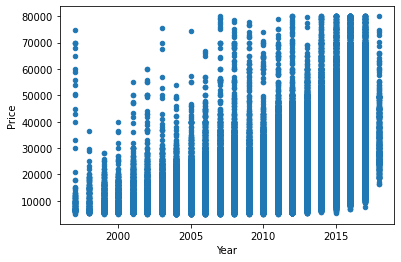

In [35]:
data.plot(kind='scatter', y='Price', x='Year')

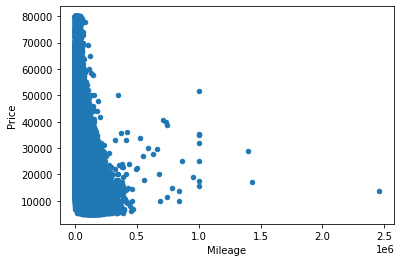

In [36]:
data.plot(kind='scatter', y='Price', x='Mileage')

In [37]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

# Exercise P2.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process. 

### Transform Data

In [3]:
data_dummy = pd.get_dummies(data)

In [4]:
y = data_dummy.Price.values
X = data_dummy.drop('Price', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### First Method: Bagging Linear Regression With Boostrap Sustitution



This implementation is based on [Bagged Avering of Regression Models](https://link.springer.com/content/pdf/10.1007%2F0-387-34224-9_7.pdf) and whit some of our code.

In [10]:
def BaggedLinearRegressorCV(cants = 50000, cantmdl = 20, kf = 10, mdl = LinearRegression()):
  '''
  Bagging Linear Regression with Boostrap

  Parameters:
  cants (int): samples quantity from original train to input in the model
  cantmdl (int): models quantity to do.
  kf (int): folds quantity to implements with cross-validation.
  mdl (object): models to be used to train with KFolds and ensemble with weighet averange.

  Returns:
  double: RMSE, Root mean square of errors about bagging model.
  array: alpha, Weighet averange vector to minimaze errors.
  array objects: mdls, vector with models used.
  '''
  # Create initial values
  mdls = list() 
  rmses = list()
  
  # Boostrap selection
  for j in range(cantmdl):
    print('Model: ', j)
    bestrmse = 9999999999
    bestmdl = 0
    Xi = sample(range(1, len(list(X_train))), cants)
    X_train1 = X_train[Xi]
    y_train1 = y_train[Xi]
    ks = round(cants/kf,0).astype(int)

    # CV with K-Fold defined in KF var
    for i in range(kf):
        X_train2 = pd.DataFrame(X_train1)
        y_train2 = pd.DataFrame(y_train1)
        X_train2 = X_train2[invert(X_train2.index.isin(arange(i*ks,(i+1)*ks)))]
        y_train2 = y_train2[invert(y_train2.index.isin(arange(i*ks,(i+1)*ks)))]
        X_test2 = X_train1[arange(i*ks,(i+1)*ks)]
        y_test2 = y_train1[arange(i*ks,(i+1)*ks)]
        mdl.fit(X_train2,y_train2)
        rmse = mean_squared_error(mdl.predict(X_test2),y_test2)**0.5
        print('\t rmse Fold ',i,' = %3.f' %rmse)
        if rmse < bestrmse:
            bestrmse = rmse;
            bestmdl = mdl;
    mdls.append(bestmdl)
    rmses.append(bestrmse)

  # Apply weight vote
  error = zeros(cantmdl)
  for i in range(cantmdl):
      error[i]=(mean_squared_error(mdls[i].predict(X_test),y_test)**0.5)
  alpha = (1 - error) / (1 - error).sum()
  alpha = (1/alpha)/sum(1/alpha)
  pred = pd.DataFrame(0, index=arange(len(y_test)), columns=range(cantmdl))
  for i in range(cantmdl):
      pred[i] = (pd.DataFrame(mdls[i].predict(X_test)))
  RMSE = mean_squared_error((pred * alpha).sum(axis=1),y_test)**0.5
  print('RMSE in Bagged Linear Model = %3.f' %RMSE)


  return RMSE,  alpha, mdls

In [68]:
RMSE, alpha, mdls = BaggedLinearRegressorCV(cantmdl=3)

Model:  0
	 rmse Fold  0  = 4534
	 rmse Fold  1  = 4371
	 rmse Fold  2  = 4387
	 rmse Fold  3  = 4501
	 rmse Fold  4  = 4355
	 rmse Fold  5  = 4357
	 rmse Fold  6  = 4473
	 rmse Fold  7  = 4369
	 rmse Fold  8  = 4432
	 rmse Fold  9  = 4384
Model:  1
	 rmse Fold  0  = 4325
	 rmse Fold  1  = 4537
	 rmse Fold  2  = 4660
	 rmse Fold  3  = 4448
	 rmse Fold  4  = 4591
	 rmse Fold  5  = 4292
	 rmse Fold  6  = 4626
	 rmse Fold  7  = 4464
	 rmse Fold  8  = 4428
	 rmse Fold  9  = 4484
Model:  2
	 rmse Fold  0  = 4430
	 rmse Fold  1  = 4385
	 rmse Fold  2  = 4585
	 rmse Fold  3  = 4354
	 rmse Fold  4  = 4350
	 rmse Fold  5  = 4384
	 rmse Fold  6  = 4565
	 rmse Fold  7  = 4131
	 rmse Fold  8  = 4133
	 rmse Fold  9  = 4397
RMSE in Bagged Linear Model = 4441


In [66]:
RMSE

4448.329298881056

In [69]:
alpha

array([0.33333333, 0.33333333, 0.33333333])

In [70]:
mdls

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)]

 ### Second Method: Super Learner

This implementation is based on [Super Learner](https://www.degruyter.com/view/journals/sagmb/6/1/article-sagmb.2007.6.1.1309.xml.xml) and some modifications.

The super learner algorithm is an application of stacked generalization, called stacking or blending, to k-fold cross-validation where all models use the same k-fold splits of the data and a meta-model is fit on the out-of-fold predictions from each model.

This implementation isn´t use manually k-fold because the finallly aim is to compare those methods and sustent the razons of selected model we choose.

In [5]:
def get_models():
  models = list()
  models.append(AdaBoostRegressor())
  models.append(GradientBoostingRegressor())
  # models.append(BaggingRegressor(n_estimators=10, n_jobs = -1))
  models.append(RandomForestRegressor(n_estimators=10, n_jobs = -1))
  models.append(ExtraTreesRegressor(n_estimators=10, n_jobs = -1))
  #models.append(XGBRegressor(n_jobs = -1))
  return models

In [6]:
def get_out_of_fold_predictions(X, y, models):
  meta_X, meta_y = list(), list()
  # define split of data
  kfold = KFold(n_splits=10, shuffle=True)
	# enumerate splits
  for train_ix, test_ix in kfold.split(X):
    fold_yhats = list()
    # get data
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    meta_y.extend(test_y)
    # fit and make predictions with each sub-model
    for model in models:
      print(model)
      model.fit(train_X, train_y)
      yhat = model.predict(test_X)
      # store columns
      fold_yhats.append(yhat.reshape(len(yhat),1))
    # store fold yhats as columns
    meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y)

In [7]:
# fit all base models on the training dataset
def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)

In [8]:
# fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()#SVR()
	model.fit(X, y)
	return model

In [9]:
# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		mse = mean_squared_error(y, yhat)
		print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))

In [10]:
# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict(X)
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)

In [ ]:
# get models
models = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=-1,
                 oob_score=False, random_state=

In [ ]:
# fit base models
fit_base_models(X, y, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(X_val, y_val, models)
# evaluate meta model
yhat = super_learner_predictions(X_val, models, meta_model)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

[00:44:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AdaBoostRegressor: RMSE 11092.620
GradientBoostingRegressor: RMSE 6686.566
BaggingRegressor: RMSE 4485.472
RandomForestRegressor: RMSE 4526.489
ExtraTreesRegressor: RMSE 4466.105
XGBRegressor: RMSE 6690.930
Super Learner: RMSE 4302.434


### Conclusion

As we saw, the models have similar RMSE; this is interesting for us because we thought that the more complex models would have less MSE returned, but,  we've got a similar MSE with the two models: one with many 'basic' models like the Linear Regressions, inside a bagging agregation and traning data sampled using boostrap with ensemble of n:

 * LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).

In the other hand, we have a ensemble with two stages. The first using:

* AdaBoostRegressor()
* GradientBoostingRegressor()
* BaggingRegressor(n_estimators=10, n_jobs = -1)
* RandomForestRegressor(n_estimators=10, n_jobs = -1)
* ExtraTreesRegressor(n_estimators=10, n_jobs = -1)
* XGBRegressor(n_jobs = -1)

Next, the result was going to second stage. In this stage, the output of the first stage is used as input for a linear regression.  

However, those´re competitive models generally used to predict/forecast and have a low error tolerance. And now, we asking: what is the best model? If, we check the priorities doing a Machine Learning System, we determined some aspects:

1. The fit of the model to the data.
2. The capability to consume hardware.
3. The complex of model or ensemble.

One of the most important aspects in machine learning models deployment is the hardware consumption because if the adoption is too complex, expensive or slow to use, the lifetime and maintenance of the project will be off-putting and if the complexity of this is excessive, would be overkill deploy it from some data. 

Finally, in this terms and keeping in mind that the important id 'Keep it simple' the selected model is the Bagging Linear Regression wich has an RMSE of 4448. 



# Exercise P2.2 (50%)

Create an API of the model.

Example:
![](https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/notebooks/images/img015.PNG)

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine

## API

You can see the hosted API in AWS click [here](http://ec2-3-14-9-184.us-east-2.compute.amazonaws.com:8888/)

In [ ]:
joblib.dump(mdls, 'model_lr.pkl', compress=3)

In [ ]:
pd.DataFrame(alpha).to_csv('alpha.csv')

The files nedded to deploy the model in a API, was:

* model_lr.pkl: The binary file with model.
* alpha.csv: The csv file with weighets of models.

### Model running in local machine

![](https://raw.githubusercontent.com/NecesitoUnNick/P2/master/img/apilocal01.png)

![](https://raw.githubusercontent.com/NecesitoUnNick/P2/master/img/apilocal02.png)

### Conclusion


with regard to the development of the API. We had some interesting challenges, such as the process of converting from a single input to a dummy dataframe or the fact of using parallel models, since using models that were trained in parallel, they make the forecasting process equally parallel and we had to retrain the model so it wouldn't hang up looking for threads in the server. We used a weighted average for the models, implementing it also cost us time, since it was necessary to replicate it in the server, just like the notebook. 

Moreover, we managed to use it on the server and start the required tests to upload it in production to the Amazon server.